## Helpers

In [8]:
import pandas as pd
import os
from glob import glob

def load_and_merge_csvs(folder_path, method_name):
    """
    Load and merge all CSV files in a given folder.
    
    Parameters:
        folder_path (str): Path to the folder containing the CSV files.
        method_name (str): Name of the method to tag (e.g. "CoT").
    
    Returns:
        pd.DataFrame: Merged DataFrame with method and run columns.
    """
    # Find all CSV files in the folder
    csv_files = sorted(glob(os.path.join(folder_path, "*.csv")))

    dataframes = []
    for i, file_path in enumerate(csv_files):
        df = pd.read_csv(file_path)
        df["method"] = method_name
        df["run"] = i + 1
        dataframes.append(df)

    # Merge all into one DataFrame
    merged_df = pd.concat(dataframes, ignore_index=True)
    return merged_df

## Load cleaned data

### CoT

In [15]:
cot_all = load_and_merge_csvs("results/cot_few-shot_clean", method_name="CoT")
cot_all.head()

,id,subject,ground_truth,predicted,correct,method,run
0,questao_01,Languages,A,A,True,CoT,1
1,questao_02,Languages,A,D,False,CoT,1
2,questao_03,Languages,C,C,True,CoT,1
3,questao_04,Languages,E,E,True,CoT,1
4,questao_05,Languages,A,A,True,CoT,1


### CoVe

In [16]:
cove_all = load_and_merge_csvs("results/cove_few-shot_clean", method_name="CoVe")
cove_all.head()

,id,subject,ground_truth,predicted,correct,initial_answer,method,run
0,questao_01,Languages,A,A,True,A,CoVe,1
1,questao_02,Languages,A,D,False,D,CoVe,1
2,questao_03,Languages,C,C,True,C,CoVe,1
3,questao_04,Languages,E,D,False,D,CoVe,1
4,questao_05,Languages,A,A,True,A,CoVe,1


### Self-Refine

In [17]:
selfrefine_all = load_and_merge_csvs("results/self-refine_few-shot_clean", method_name="Self-Refine")
selfrefine_all.head()

,id,subject,ground_truth,predicted,correct,initial_answer,method,run
0,questao_01,Languages,A,A,True,A,Self-Refine,1
1,questao_02,Languages,A,D,False,D,Self-Refine,1
2,questao_03,Languages,C,C,True,C,Self-Refine,1
3,questao_04,Languages,E,E,True,D,Self-Refine,1
4,questao_05,Languages,A,A,True,A,Self-Refine,1


### Dataset Summary

In [20]:
print(f"{'Method':<15}{'Rows':<10}{'Columns':<10}{'Runs':<10}{'Unique IDs':<15}")
print("-" * 60)
print(f"{'CoT':<15}{cot_all.shape[0]:<10}{cot_all.shape[1]:<10}{cot_all['run'].nunique():<10}{cot_all['id'].nunique():<15}")
print(f"{'CoVe':<15}{cove_all.shape[0]:<10}{cove_all.shape[1]:<10}{cove_all['run'].nunique():<10}{cove_all['id'].nunique():<15}")
print(f"{'Self-Refine':<15}{selfrefine_all.shape[0]:<10}{selfrefine_all.shape[1]:<10}{selfrefine_all['run'].nunique():<10}{selfrefine_all['id'].nunique():<15}")


Method         Rows      Columns   Runs      Unique IDs     
------------------------------------------------------------
CoT            540       7         3         180            
CoVe           540       8         3         180            
Self-Refine    360       8         2         180            


## Stability Check

In [29]:
# Group by method and run, then calculate mean accuracy
accuracy_by_run = pd.concat([cot_all, cove_all, selfrefine_all], ignore_index=True)
run_stats = accuracy_by_run.groupby(["method", "run"])["correct"].mean().reset_index()

print("Per-run Accuracy:")
print(run_stats.pivot(index="run", columns="method", values="correct").round(3))

Per-run Accuracy:
method    CoT   CoVe  Self-Refine
run                              
1       0.672  0.672        0.700
2       0.722  0.683        0.694
3       0.661  0.650          NaN


### Standard Deviation per Method

#### Variability between test runs:
Low std = more stable

high std = more variable

In [30]:
std_by_method = run_stats.groupby("method")["correct"].std().round(4)
print("\nStandard deviation of accuracy per method:")
print(std_by_method)


Standard deviation of accuracy per method:
method
CoT            0.0326
CoVe           0.0170
Self-Refine    0.0039
Name: correct, dtype: float64


### Merge all 

In [22]:
full_df = pd.concat([cot_all, cove_all, selfrefine_all], ignore_index=True)

### Mean Accuracy and StD across runs

In [34]:
full_df.groupby("method")["correct"].mean()

method
CoT            0.685185
CoVe           0.668519
Self-Refine    0.697222
Name: correct, dtype: float64

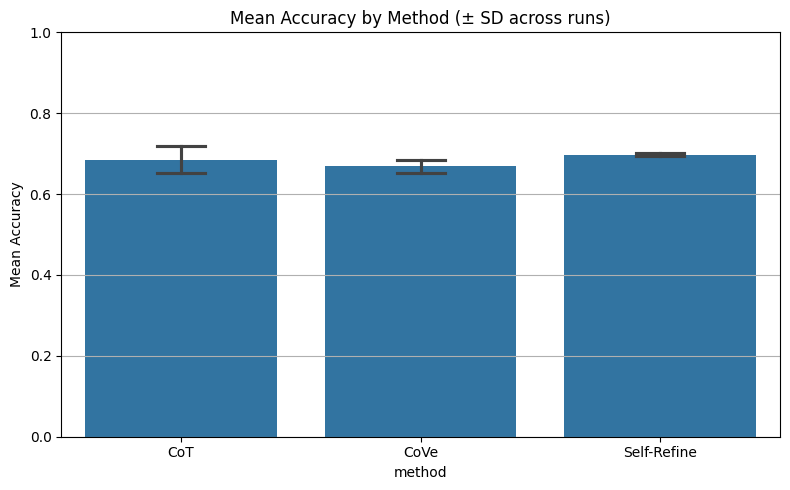

In [35]:
plt.figure(figsize=(8, 5))
sns.barplot(data=run_stats, x="method", y="correct", errorbar="sd", capsize=0.2)

plt.title("Mean Accuracy by Method (± SD across runs)")
plt.ylabel("Mean Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Accuracy per Subject

### Calculate mean and std of accuracy per method and subject

In [49]:
grouped = full_df.groupby(["subject", "method"])["correct"]
mean_df = grouped.mean().reset_index(name="mean_accuracy")
std_df = grouped.std().reset_index(name="std_accuracy")

# Merge mean and std together
stats_df = pd.merge(mean_df, std_df, on=["subject", "method"])

/var/folders/kk/2yj1lx6946x1xhfcryhkfv9w0000gn/T/ipykernel_70145/2643712454.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  ax = sns.barplot(


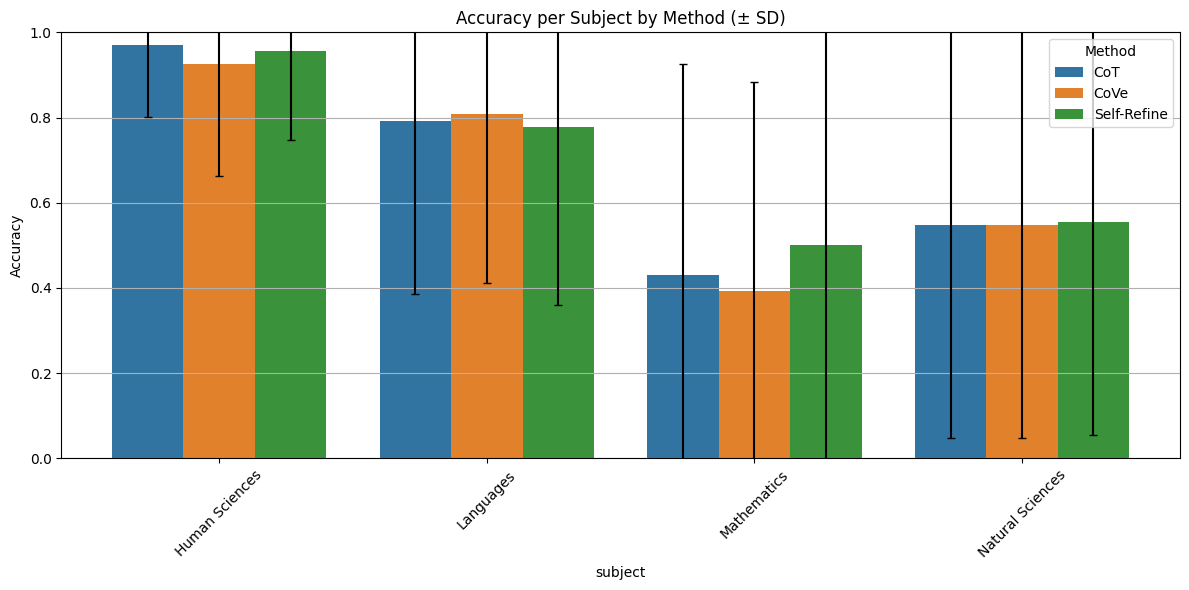

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot without error bars
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=stats_df,
    x="subject",
    y="mean_accuracy",
    hue="method",
    capsize=0.1,
    errwidth=0  # Disable automatic error bars
)

# Add standard deviation error bars manually
# Get method and subject ordering as used in the plot
subjects = stats_df["subject"].unique()
methods = stats_df["method"].unique()

# Get bar containers to find correct x positions
bar_containers = ax.containers

# For each bar, get its x position and add the corresponding std
for bars, method in zip(bar_containers, methods):
    for bar, (_, row) in zip(bars, stats_df[stats_df["method"] == method].iterrows()):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        err = row["std_accuracy"]
        ax.errorbar(x, y, yerr=err, fmt='none', c='black', capsize=3)

# Final formatting
plt.title("Accuracy per Subject by Method (± SD)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title="Method")
plt.tight_layout()
plt.show()
